## Setup
RDKit is an open source toolkit for cheminformatics and machine learning. This toolkit come in handy
if one is into drug discovery domain. In this example, RDKit is used to conviently
and efficiently transform SMILES to molecule objects, and then from those obtain sets of atoms
and bonds.
Quoting from
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/)):
**"SMILES expresses the structure of a given molecule in the form of an ASCII string.
The SMILES string is a compact encoding which, for smaller molecules, is relatively human-readable.
Encoding molecules as a string both alleviates and facilitates database and/or web searching
of a given molecule. RDKit uses algorithms to accurately transform a given SMILES to
a molecule object, which can then be used to compute a great number of molecular properties/features."**

In [4]:
!pip -q install rdkit-pypi==2021.9.4

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import rdkit
import ast

from rdkit.Chem import QED
from tensorflow import keras
from rdkit import Chem, RDLogger
from tensorflow.keras import layers
from rdkit.Chem.Draw import MolsToGridImage

RDLogger.DisableLog("rdApp.*")

## Dataset

We use CovidDrug dataset. The dataset comes with molecule
formula in SMILE representation along with their respective molecular properties such as
 **QED** (Qualitative Estimate of Drug-likeness).

In [6]:
df = pd.read_csv("/content/Best.csv")
df.head()

,smiles
0,COCCCCC(=O)NC1CC(c2cccc(Cl)c2)C1c1ccccc1-c1c(C...
1,CCOCCNC(=N)NCCOc1ccccc1-c1ccccc1
2,CCNCCCNCc1nccn1CCCN1CCCCC1
3,CNCCC(C)NC(=O)Cn1cc(CNC2CC2)cn1
4,Fc1nscc1I


In [7]:
df['molfromsmiles']=df.smiles.apply(Chem.MolFromSmiles)
df['qed']=df.molfromsmiles.apply(QED.qed)
df.head()

,smiles,molfromsmiles,qed
0,COCCCCC(=O)NC1CC(c2cccc(Cl)c2)C1c1ccccc1-c1c(C...,<rdkit.Chem.rdchem.Mol object at 0x7f834e2f7040>,0.165770
1,CCOCCNC(=N)NCCOc1ccccc1-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f834e2f6ce0>,0.376325
2,CCNCCCNCc1nccn1CCCN1CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x7f834e2f6e00>,0.612533
3,CNCCC(C)NC(=O)Cn1cc(CNC2CC2)cn1,<rdkit.Chem.rdchem.Mol object at 0x7f834e2f6e60>,0.605836
4,Fc1nscc1I,<rdkit.Chem.rdchem.Mol object at 0x7f834e2f7160>,0.618720


In [8]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", \
                  "P", "Cl", "Br"]'
bond_mapping = {
    "SINGLE": 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    "TRIPLE": 2,
    2: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    3: Chem.BondType.AROMATIC,
}
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df['smiles'].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))

Max molecule size: 66
Character set Length: 11


## Hyperparameters

In [9]:
BATCH_SIZE = 32
EPOCHS =10

VAE_LR = 5e-4
NUM_ATOMS = 120 # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space

In [10]:
def smiles_to_graph(smiles):

    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

def graph_to_molecule(graph):

    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

## Build Dataloader

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, mapping, max_len, batch_size=6, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.mapping = mapping
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        mol_features, mol_property = self.data_generation(batch)

        return mol_features, mol_property

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, idx):
        """
        Load molecules adjacency matrix and features matrix from SMILE representation
        and their respective SAS value.
        """
        qed = self.data.loc[idx]['qed']

        adjacency, features = smiles_to_graph(self.data.loc[idx]['smiles'])

        return adjacency, features, qed


    def data_generation(self, batch):

        x1 = np.empty((self.batch_size, BOND_DIM, self.max_len, self.max_len))
        x2 = np.empty((self.batch_size, self.max_len, len(self.mapping)))
        x3 = np.empty((self.batch_size, ))

        for i, batch_id in enumerate(batch):
            x1[i,], x2[i,], x3[i,] = self.load(batch_id)

        return [x1, x2], x3


##  Generate training set

In [12]:
train_df = df.sample(frac=0.75,random_state=42) #random state is a seed value
test_df = df.drop(train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [13]:
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

## Build the Encoder and Decoder
The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
These features are processed via a Graph Convolution layer, then are flattened and
processed by several Dense layers to derive `z_mean` and `log_var`, the
latent-space representation of the molecule.

In [14]:
def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units,dropout_rate ):

    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)

    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder

def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):

    latent_inputs = keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)


    decoder = keras.Model(latent_inputs, outputs=[x_adjacency, x_features], name="decoder")

    return decoder

## Build Sampling layer

In [15]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the VAE
This model is trained to optimize four losses:
* Categorical crossentropy
* KL divergence loss
* Property prediction loss
* Graph loss (gradient penalty)

In [16]:
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = layers.Dense(1)
        self.max_len = max_len

        self.train_total_loss_tracker = keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")

    def train_step(self, data):
        mol_features, mol_property = data
        graph_real = mol_features
        self.batch_size = tf.shape(mol_property)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, property_prediction, \
             reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                             training=True)
            graph_generated = [reconstruction_adjacency, reconstruction_features]
            total_loss = self.calculate_loss(z_log_var,
                                             z_mean,
                                             mol_property,
                                             property_prediction,
                                             graph_real,
                                             graph_generated,
                                             is_train=True)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.train_total_loss_tracker.result(),
        }

    def test_step(self, data):
        mol_features, mol_property = data
        z_mean, z_log_var, property_prediction, \
        reconstruction_adjacency, reconstruction_features = self(mol_features,
                                                                training=False)
        total_loss = self.calculate_loss(z_log_var,
                                        z_mean,
                                        mol_property,
                                        property_prediction,
                                        graph_real=mol_features,
                                        graph_generated=[reconstruction_adjacency,
                                                         reconstruction_features],
                                        is_train=False)

        self.val_total_loss_tracker.update_state(total_loss)
        return {
            "loss": self.val_total_loss_tracker.result()
        }

    def calculate_loss(self,
                       z_log_var,
                       z_mean,
                       mol_property,
                       property_prediction,
                       graph_real,
                       graph_generated,
                       is_train):
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        adjacency_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.categorical_crossentropy(
                                                        adjacency_real,
                                                        adjacency_generated
                                                        ),
                                                        axis=(1,2)
                    )
            )
        features_reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.categorical_crossentropy(
                                                        features_real,
                                                        features_generated
                                                        ),
                                                        axis=(1)
                    )
            )
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1)
        kl_loss = tf.reduce_mean(kl_loss)

        property_prediction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(mol_property,
                                                property_prediction)
        )

        if is_train:
            graph_loss = self._gradient_penalty(graph_real, graph_generated)
        else:
            graph_loss = 0

        return kl_loss + property_prediction_loss + graph_loss + adjacency_reconstruction_loss + features_reconstruction_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _,_ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = model.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]

    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])

        reconstruction_adjacency, reconstruction_features = self.decoder(z)

        property_prediction = self.property_prediction_layer(z_mean)

        return z_mean, log_var, property_prediction, reconstruction_adjacency, reconstruction_features

## Train the model

In [17]:
train_loader = DataGenerator(
    data=train_df[:8000],
    mapping = SMILE_to_index,
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
)

validation_loader = DataGenerator(
    data=test_df[:8000],
    mapping = SMILE_to_index,
    max_len = NUM_ATOMS,
    batch_size=BATCH_SIZE
    )

In [18]:
vae_optimizer = tf.keras.optimizers.Adam(
    learning_rate=VAE_LR
)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM)
)

model = MoleculeGenerator(encoder,
                          decoder,
                          MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit(train_loader,
                    epochs=EPOCHS,
                    validation_data=validation_loader)

Epoch 1/10
50/50 [==============================] - 23s 218ms/step - loss: 69225.7442 - val_loss: 68886.2812
Epoch 2/10
50/50 [==============================] - 5s 95ms/step - loss: 68888.6640 - val_loss: 68871.9609
Epoch 3/10
50/50 [==============================] - 8s 163ms/step - loss: 68885.5454 - val_loss: 68870.8047                                                                                                    
Epoch 4/10
50/50 [==============================] - 8s 154ms/step - loss: 68913.9121 - val_loss: 68853.5781                                                                                                     
Epoch 5/10
50/50 [==============================] - 10s 193ms/step - loss: 68855.6428 - val_loss: 68884.0000                                                                                                    
Epoch 6/10
50/50 [==============================] - 8s 172ms/step - loss: 68907.6960 - val_loss: 68939.1094                                                   

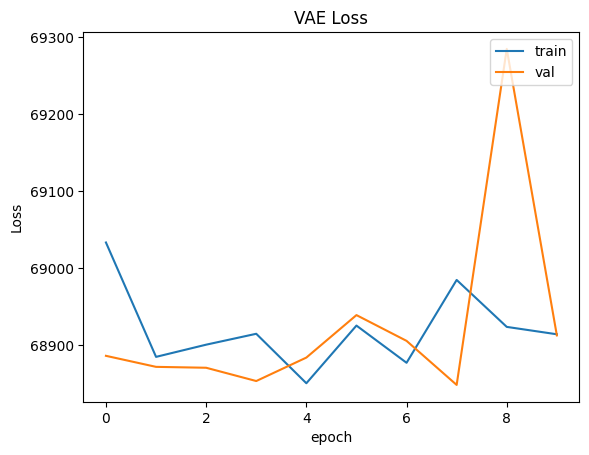

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VAE Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Model Inferencing

We would be inferring our model to predict over random latent space and try to generate new valid molecules.

### Generate unique Molecules with the model

3/3 [==============================] - 0s 4ms/step


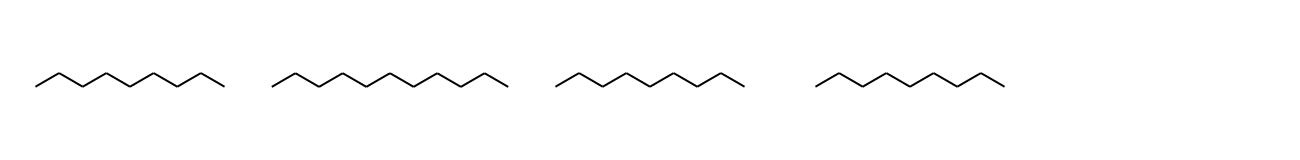

In [20]:
molecules = model.inference(70)

MolsToGridImage(
    [m for m in molecules if m is not None][:70], molsPerRow=5, subImgSize=(260, 160)
)

### Display latent space clusters with respect to molecular properties

50/50 [==============================] - 0s 5ms/step


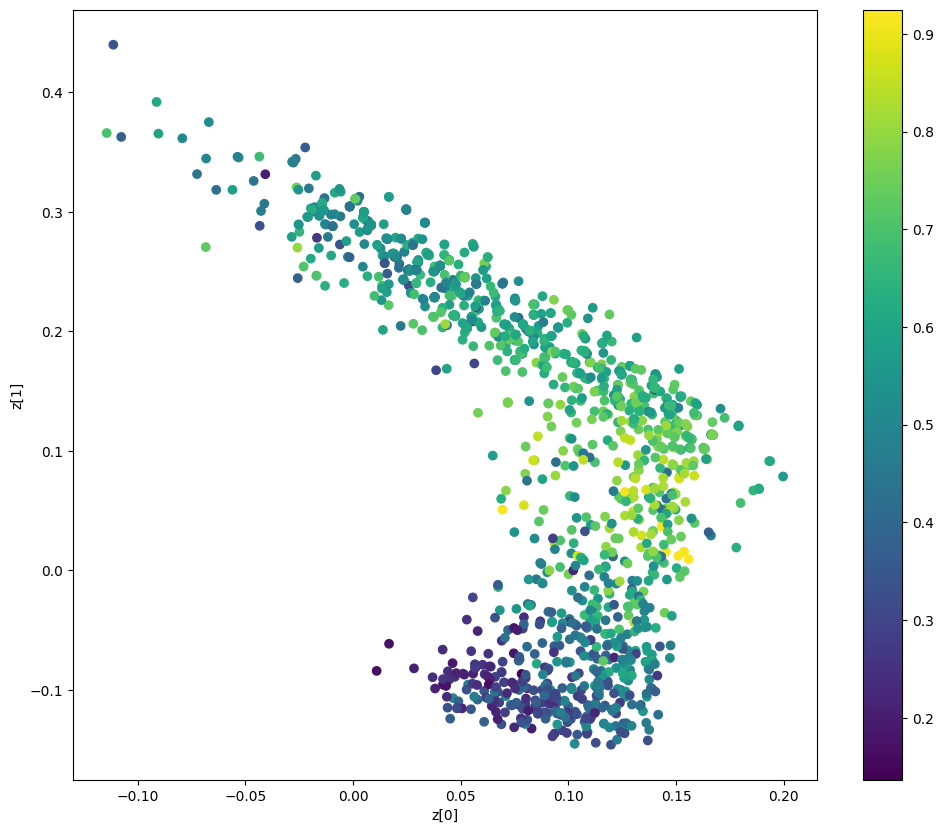

In [21]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the property in the latent space
    z_mean, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


train_data = DataGenerator(
                            data=train_df,
                            mapping = SMILE_to_index,
                            max_len = NUM_ATOMS,
                            batch_size=8000
                        )
x_train, y_train = next(iter(train_data))
plot_label_clusters(model, x_train, y_train)